In [1]:
# Necessary Imports
import tensorflow as tf
import numpy as np 
import sklearn
from sklearn.preprocessing import MinMaxScaler
# Check versions
print('tensorflow: %s' %tf.__version__)
print('numpy: %s' % np.__version__) 
print('sklearn: %s' % sklearn.__version__)

# Installs 
! pip install opencv-python
! pip install opencv-python
! pip install graphviz
# Visualization

import cv2 # 
print('OpenCV: %s' % cv2.__version__) 
import matplotlib 
import matplotlib.pyplot as plt 
print('matplotlib: %s' % matplotlib.__version__) 
import graphviz 
print('graphviz: %s' % graphviz.__version__) 

tensorflow: 2.11.0
numpy: 1.24.1
sklearn: 1.2.0
OpenCV: 4.7.0
matplotlib: 3.6.2
graphviz: 0.20.1


In [2]:
import sys
import os

# Assign working directory to a variable
working_dir=os.path.dirname(sys.path[0])

In [3]:
working_dir

'c:\\Users\\Samia\\Documents\\ProjectsGithub'

In [4]:
# Locate Images
ImgLocation=working_dir +'\Papers-Implementation\images\\'

In [5]:
# Choose Images Class 'the artist'
artist_class = set(["Edvard_Munch"])

In [6]:
# Store Img paths in a list
ImgPaths=[]
for artist in artist_class:
    for img in list(os.listdir(ImgLocation+artist)):
        ImgPaths=ImgPaths+[ImgLocation + artist + '\\'+ img]

In [7]:
# Load images 
# resize to 64 by 64
imgs_data=[]
for img in ImgPaths:
    img = cv2.imread(img)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs_resized = cv2.resize(img, (64, 64))
    imgs_data.append(imgs_resized)
    
# Create Numpy array of images standardized 
imgs_data = np.array(imgs_data, dtype="float") / 255.0

# Show data shape
print("Shape of data_lowres: Number of Samples is :", imgs_data.shape[0],".\nImages Shape is", imgs_data.shape[1:])

Shape of data_lowres: Number of Samples is : 67 .
Images Shape is (64, 64, 3)


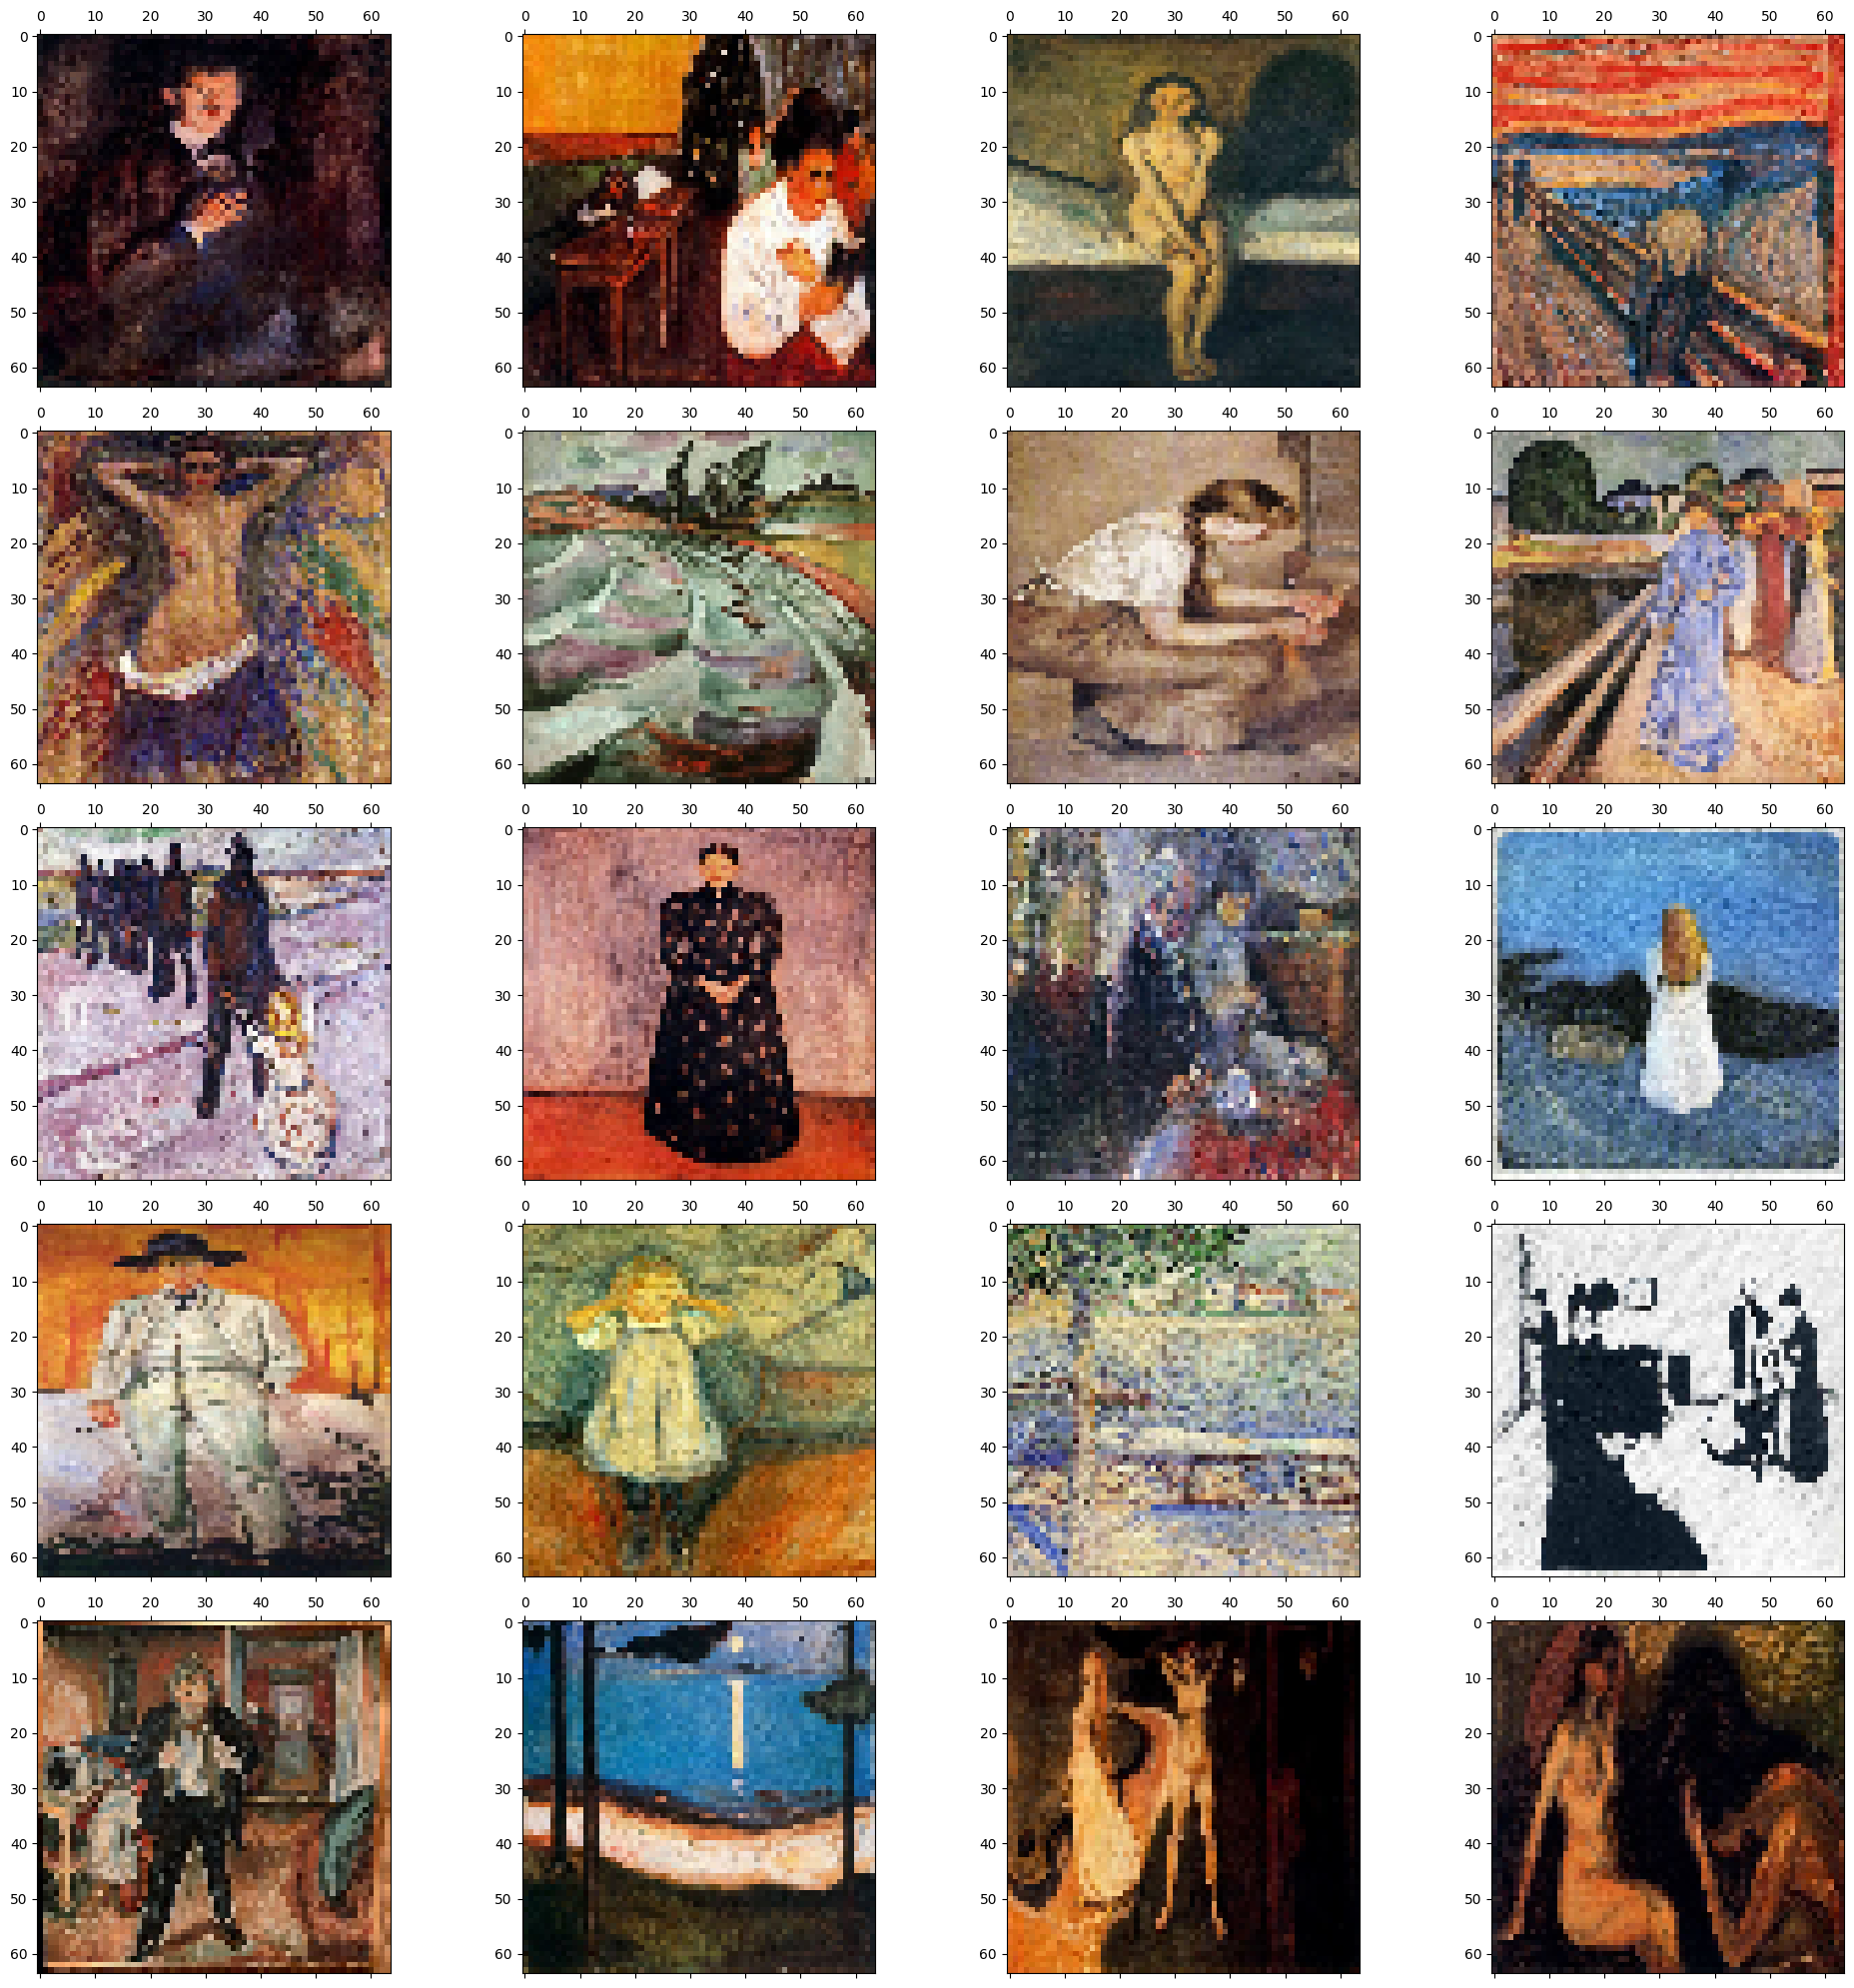

In [8]:
# Display 20 images from data
fig, axs = plt.subplots(5, 4, sharey=False, tight_layout=True, figsize=(20,20), facecolor='white')
n=0
for i in range(0,5):
    for j in range(0,4):
        axs[i,j].matshow(imgs_data[n])
        n=n+1
plt.show() 

In [9]:
# Instantiate Scaler
scaler=MinMaxScaler(feature_range=(-1, 1))

# Select images 
data=imgs_data.copy()
print("Original shape of the data: ", data.shape)

# Data must be reshaped ro one column to be scaled using MinMaxScaler
# Reshape array
data=data.reshape(-1, 1)
print(data)
print("Reshaped data: ", data.shape)

# Fit the scaler
scaler.fit(data)

# Scale the array
data=scaler.transform(data)

# Reshape back to the original shape
data=data.reshape(imgs_data.shape[0], 64, 64, 3)
print("Shape of the scaled array: ", data.shape)

Original shape of the data:  (67, 64, 64, 3)
[[0.10588235]
 [0.10196078]
 [0.11372549]
 ...
 [0.38431373]
 [0.26666667]
 [0.23921569]]
Reshaped data:  (823296, 1)
Shape of the scaled array:  (67, 64, 64, 3)


In [10]:
from tensorflow import keras
from keras.utils import plot_model

def Generator (latent_dim):

    n_input_nodes = 8 * 8 * 128
    model = keras.Sequential(
    [
    # Layer 1
    keras.layers.Dense(n_input_nodes, input_dim=latent_dim, name='Generator-H-Layer-1'),
    keras.layers.Reshape((8, 8, 128), name='Generator-H-Layer-Reshape-1'),
    
    # Layer 2
    keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-H-Layer-2'),
    keras.layers.ReLU(name='Generator-Hidden-Layer-Activation-2'),
                              
    # Layer 3
    keras.layers.Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-H-Layer-3'),
    keras.layers.ReLU(name='Generator-Hidden-Layer-Activation-3'),
    
    # Layer 4
    keras.layers.Conv2DTranspose(filters=512, kernel_size=(4,4), strides=(2,2), padding='same', name='Generator-H-Layer-4'),
    keras.layers.ReLU(name='Generator-H-Layer-Activation-4'),
    
    # Output Layer
    keras.layers.Conv2D(filters=3, kernel_size=(5,5), activation='tanh', padding='same', name='Generator-Output-Layer'),
    ],name="Generator")
    return model

# Latent Space or output space of generator
# Latent space is the space of points to feed the generator
latent_dim=200
gen_model = Generator(latent_dim)

# Show model summary and plot model diagram
gen_model.summary()


Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-H-Layer-1 (Dense)  (None, 8192)             1646592   
                                                                 
 Generator-H-Layer-Reshape-1  (None, 8, 8, 128)        0         
  (Reshape)                                                      
                                                                 
 Generator-H-Layer-2 (Conv2D  (None, 16, 16, 128)      262272    
 Transpose)                                                      
                                                                 
 Generator-Hidden-Layer-Acti  (None, 16, 16, 128)      0         
 vation-2 (ReLU)                                                 
                                                                 
 Generator-H-Layer-3 (Conv2D  (None, 32, 32, 256)      524544    
 Transpose)                                              

In [17]:
! pip uninstall pydot
! pip install pydot
plot_model(gen_model, show_shapes=True, show_layer_names=True, dpi=400)

^C
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
def Discriminator(input_shape=(64,64,3)):

    model = keras.Sequential([
        keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(2, 2), padding='same', input_shape=input_shape, name='Discriminator-Input-Layer'),
        keras.layers.LeakyReLU(alpha=0.2, name='Discriminator-H-Layer1'),
        keras.layers.Conv2D(filters=128, kernel_size=(4,4), strides=(2, 2), padding='same', name='Discriminator-H-Layer2'),
        keras.layers.LeakyReLU(alpha=0.2, name='Discriminator-H-Layer3'),
        keras.layers.Flatten(name='Discriminator-Flatten-Layer') ,
        keras.layers.Dropout(0.3, name='Discriminator-Dropout'), 
        keras.layers.Dense(1, activation='sigmoid', name='Discriminator-Output-Layer') ,
        ],name="Discriminator") 
   
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# Instantiate
dis_model = Discriminator()

# Show model summary and plot model diagram
dis_model.summary()
plot_model(dis_model, show_shapes=True, show_layer_names=True, dpi=400)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Input-Layer (  (None, 32, 32, 64)       3136      
 Conv2D)                                                         
                                                                 
 Discriminator-H-Layer1 (Lea  (None, 32, 32, 64)       0         
 kyReLU)                                                         
                                                                 
 Discriminator-H-Layer2 (Con  (None, 16, 16, 128)      131200    
 v2D)                                                            
                                                                 
 Discriminator-H-Layer3 (Lea  (None, 16, 16, 128)      0         
 kyReLU)                                                         
                                                                 
 Discriminator-Flatten-Layer  (None, 32768)          

In [20]:
# Define GAN 
def GAN(Generator, Discriminator):

    GAN = keras.models.Sequential([Generator,Discriminator])

    # Deactive training for Discriminator 
    Discriminator.trainable = False

    # Compile GAN
    
    GAN.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

    return GAN

In [25]:
# gan_model
gan_model = GAN(gen_model, dis_model)

In [26]:
gan_model.summary()
plot_model(gan_model, show_shapes=True, show_layer_names=True, dpi=400)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 64, 64, 3)         4569475   
                                                                 
 Discriminator (Sequential)  (None, 1)                 167105    
                                                                 
Total params: 4,736,580
Trainable params: 4,569,475
Non-trainable params: 167,105
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
def real_samples(n, dataset):
    
    # Samples of real data
    X = dataset[np.random.choice(dataset.shape[0], n, replace=True), :]

    # Class labels
    y = np.ones((n, 1))
    return X, y
    
    
def latent_vector(latent_dim, n):
    
    # Generate points in the latent space
    latent_input = np.random.randn(latent_dim * n)
    
    # Reshape into a batch of inputs for the network
    latent_input = latent_input.reshape(n, latent_dim)
    return latent_input
  
    
def fake_samples(generator, latent_dim, n):
    
    # Generate points in latent space
    latent_output = latent_vector(latent_dim, n)
    
    # Predict outputs (i.e., generate fake samples)
    X = generator.predict(latent_output)
    
    # Create class labels
    y = np.zeros((n, 1))
    return X, y   

In [28]:
def performance_summary(generator, discriminator, dataset, latent_dim, n=50):
    
    # Get samples of the real data
    x_real, y_real = real_samples(n, dataset)
    # Evaluate the descriminator on real data
    _, real_accuracy = discriminator.evaluate(x_real, y_real, verbose=0)
    
    # Get fake (generated) samples
    x_fake, y_fake = fake_samples(generator, latent_dim, n)
    # Evaluate the descriminator on fake (generated) data
    _, fake_accuracy = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    # summarize discriminator performance
    print("*** Evaluation ***")
    print("Discriminator Accuracy on REAL images: ", real_accuracy)
    print("Discriminator Accuracy on FAKE (generated) images: ", fake_accuracy)
    
    # Display 6 fake images
    x_fake_inv_trans=x_fake.reshape(-1, 1)
    x_fake_inv_trans=scaler.inverse_transform(x_fake_inv_trans)
    x_fake_inv_trans=x_fake_inv_trans.reshape(n, 64, 64, 3)
    
    fig, axs = plt.subplots(2, 3, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
    k=0
    for i in range(0,2):
        for j in range(0,3):
            axs[i,j].matshow(x_fake_inv_trans[k])
            k=k+1
    plt.show() 

In [29]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1001, n_batch=32, n_eval=100):
    
    # Our batch to train the discriminator will consist of half real images and half fake (generated) images
    half_batch = int(n_batch / 2)
    
    # We will manually enumare epochs 
    for i in range(n_epochs):
    
    # Discriminator training
        # Prep real samples
        x_real, y_real = real_samples(half_batch, dataset)
        # Prep fake (generated) samples
        x_fake, y_fake = fake_samples(g_model, latent_dim, half_batch)
        
        # Train the discriminator using real and fake samples
        X, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
        discriminator_loss, _ = d_model.train_on_batch(X, y)
    
    # Generator training
        # Get values from the latent space to be used as inputs for the generator
        x_gan = latent_vector(latent_dim, n_batch)
        # While we are generating fake samples, 
        # we want GAN generator model to create examples that resemble the real ones,
        # hence we want to pass labels corresponding to real samples, i.e. y=1, not 0.
        y_gan = np.ones((n_batch, 1))
        
        # Train the generator via a composite GAN model
        generator_loss = gan_model.train_on_batch(x_gan, y_gan)
        
        # Evaluate the model at every n_eval epochs
        if (i) % n_eval == 0:
            print("Epoch number: ", i)
            print("*** Training ***")
            print("Discriminator Loss ", discriminator_loss)
            print("Generator Loss: ", generator_loss)
            performance_summary(g_model, d_model, dataset, latent_dim)

1/1 [==============================] - 1s 1s/step
Epoch number:  0
*** Training ***
Discriminator Loss  0.7174427509307861
Generator Loss:  0.6922337412834167
2/2 [==============================] - 4s 1s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.0


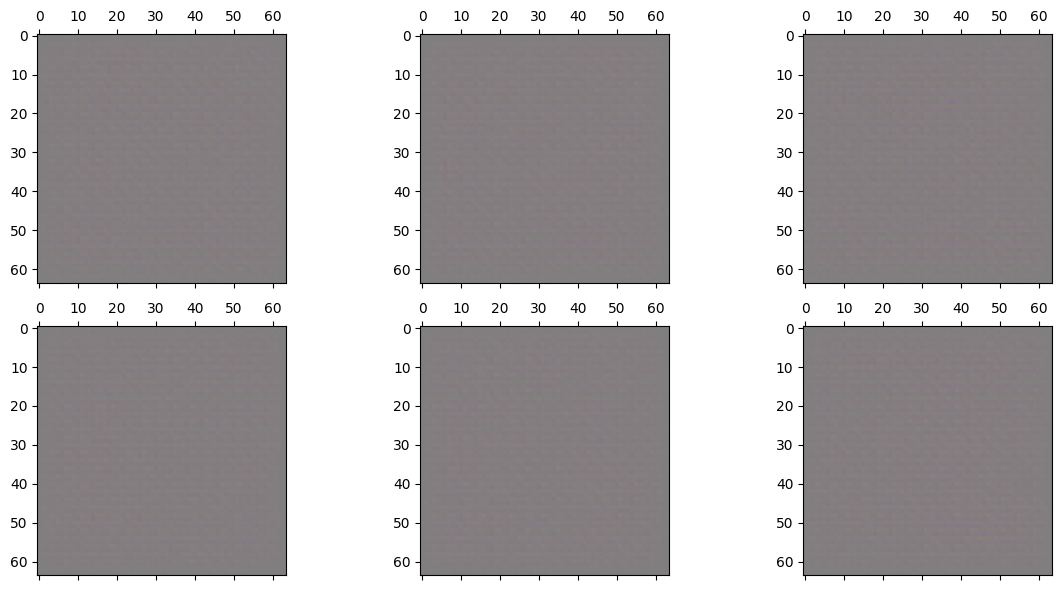

1/1 [==============================] - 1s 997ms/step
Epoch number:  100
*** Training ***
Discriminator Loss  3.420555353164673
Generator Loss:  11.995811462402344
2/2 [==============================] - 3s 1s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.6800000071525574
Discriminator Accuracy on FAKE (generated) images:  1.0


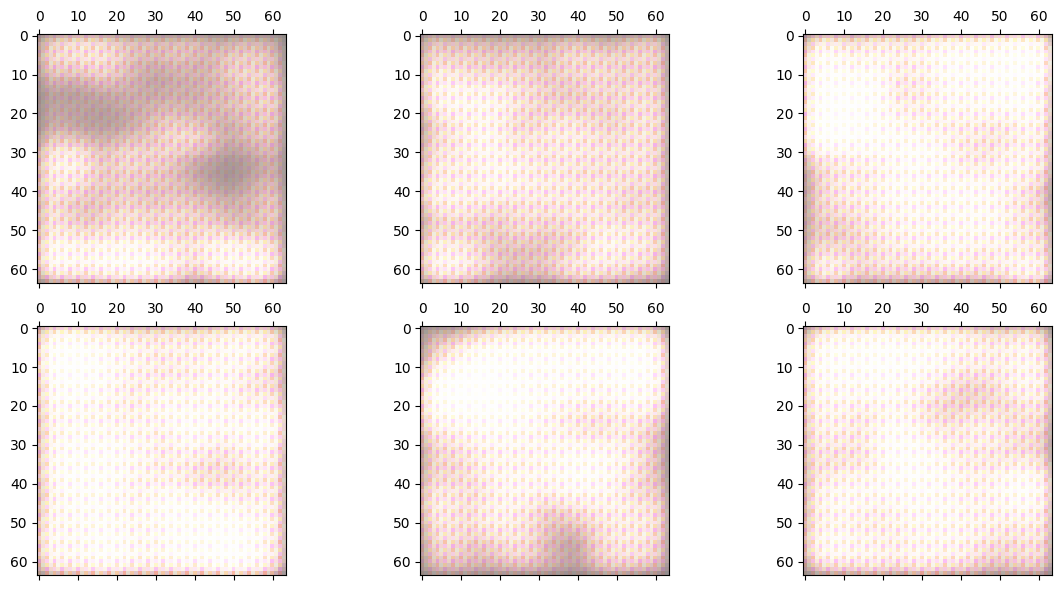

1/1 [==============================] - 1s 1s/step
Epoch number:  200
*** Training ***
Discriminator Loss  0.24099543690681458
Generator Loss:  2.2790346145629883
2/2 [==============================] - 4s 1s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8600000143051147
Discriminator Accuracy on FAKE (generated) images:  0.800000011920929


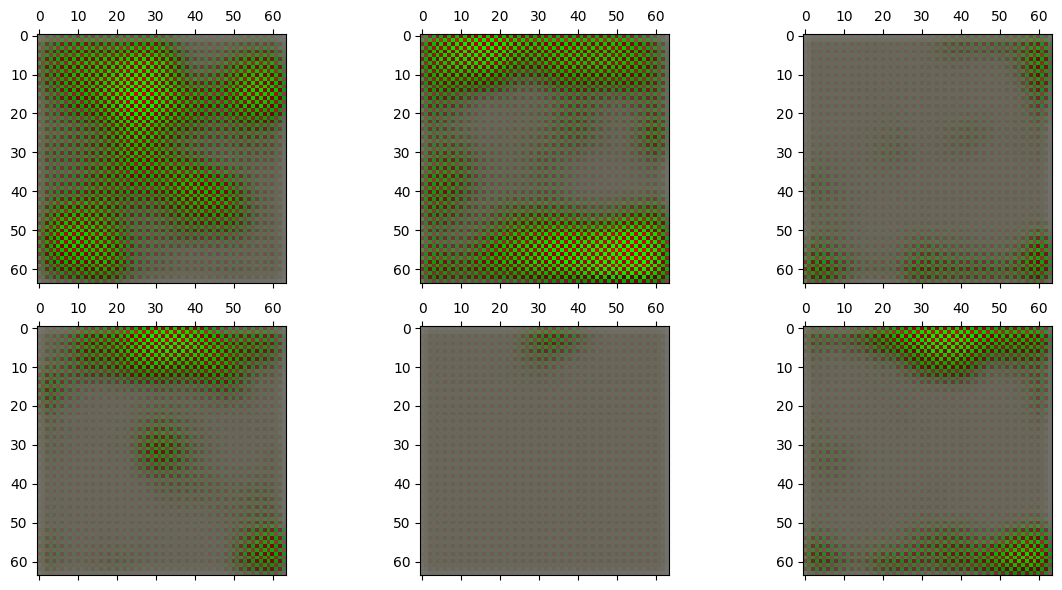

1/1 [==============================] - 1s 1s/step
Epoch number:  300
*** Training ***
Discriminator Loss  0.3004430830478668
Generator Loss:  1.8125272989273071
2/2 [==============================] - 3s 1s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8199999928474426
Discriminator Accuracy on FAKE (generated) images:  1.0


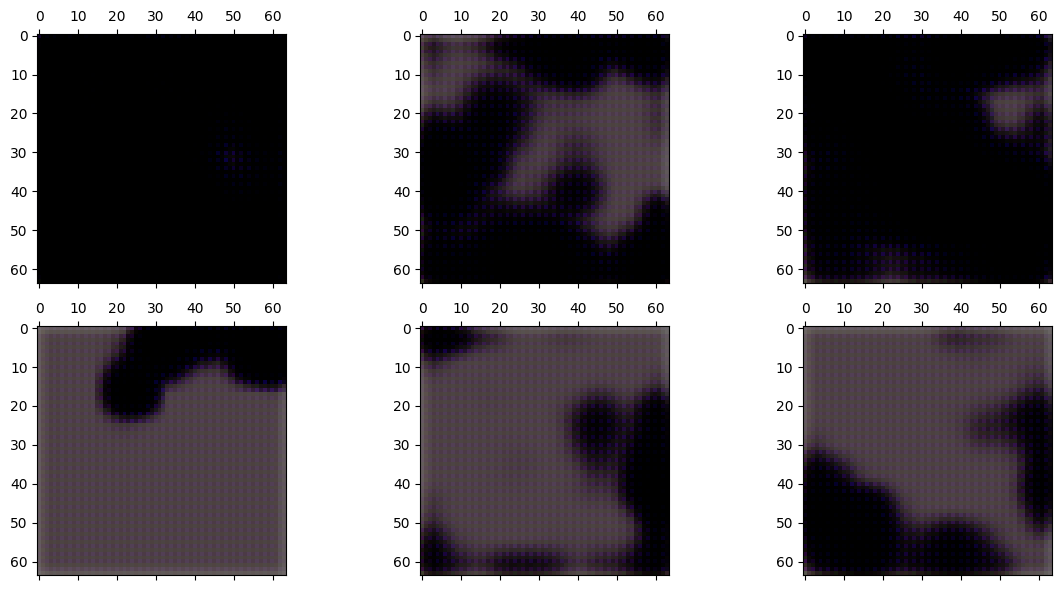

1/1 [==============================] - 1s 1s/step
Epoch number:  400
*** Training ***
Discriminator Loss  0.4085693359375
Generator Loss:  1.5289692878723145
2/2 [==============================] - 3s 1s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  1.0
Discriminator Accuracy on FAKE (generated) images:  0.7799999713897705


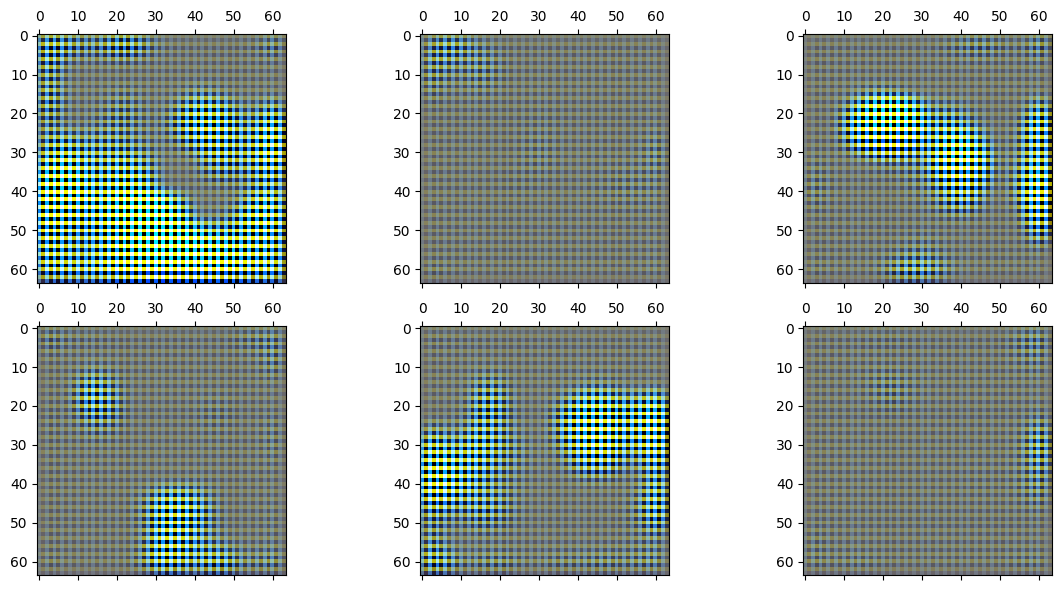

1/1 [==============================] - 1s 1s/step
Epoch number:  500
*** Training ***
Discriminator Loss  0.3095218539237976
Generator Loss:  2.1312503814697266
2/2 [==============================] - 4s 2s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8199999928474426
Discriminator Accuracy on FAKE (generated) images:  0.9800000190734863


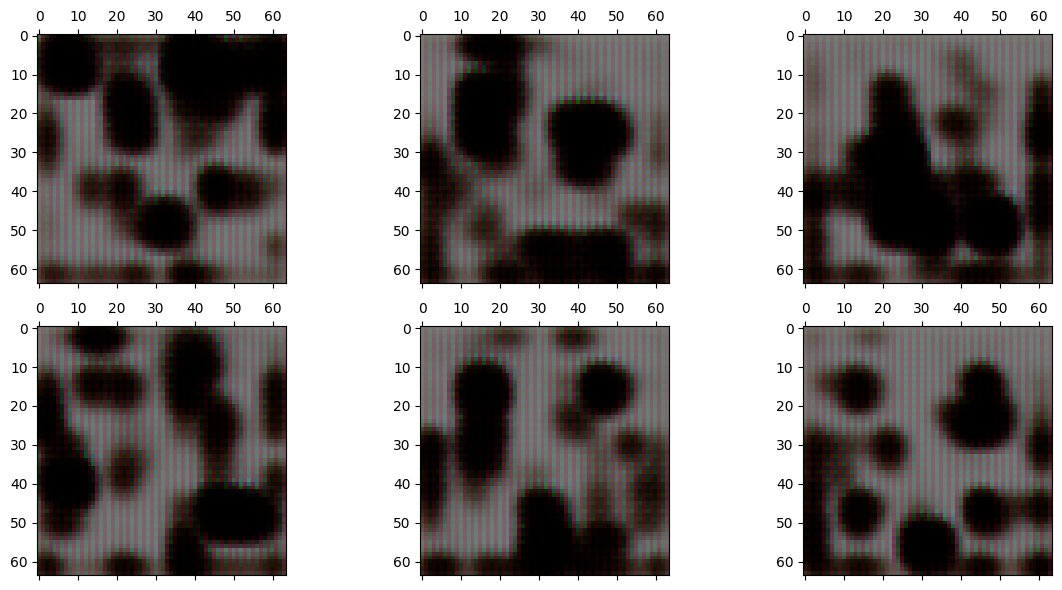

1/1 [==============================] - 1s 1s/step
Epoch number:  600
*** Training ***
Discriminator Loss  0.5880013108253479
Generator Loss:  1.759759545326233
2/2 [==============================] - 4s 1s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.2800000011920929
Discriminator Accuracy on FAKE (generated) images:  1.0


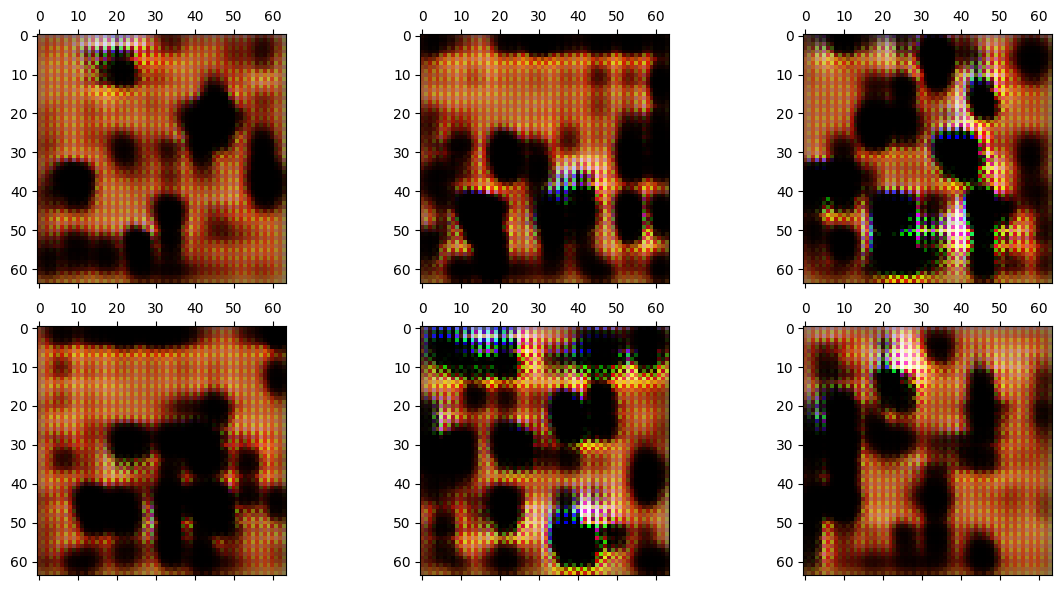

1/1 [==============================] - 1s 1s/step
Epoch number:  700
*** Training ***
Discriminator Loss  0.6315239071846008
Generator Loss:  0.7223056554794312
2/2 [==============================] - 4s 1s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.8799999952316284
Discriminator Accuracy on FAKE (generated) images:  0.4399999976158142


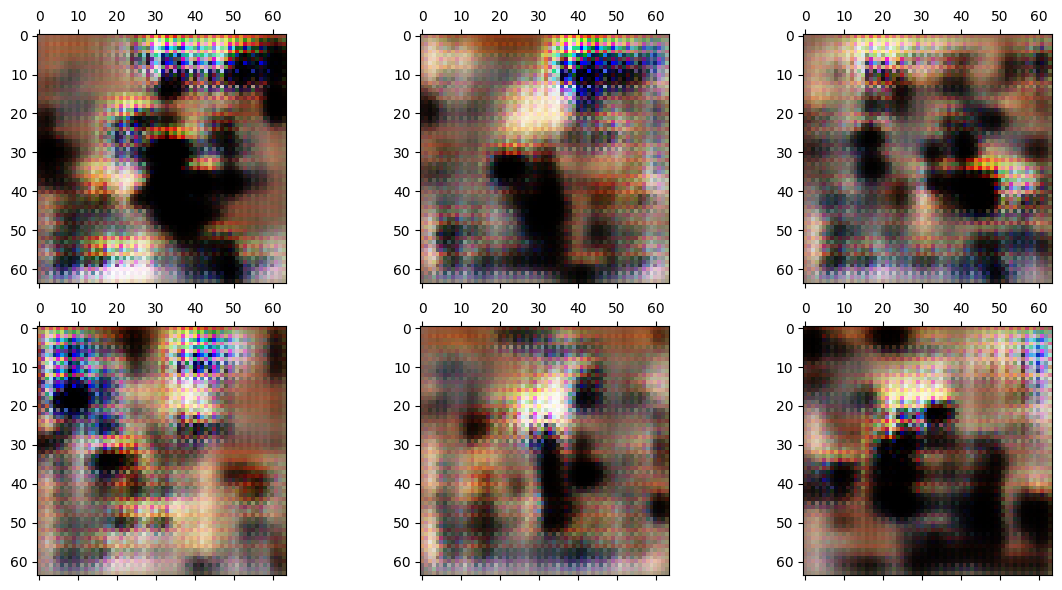

1/1 [==============================] - 1s 1s/step
Epoch number:  800
*** Training ***
Discriminator Loss  0.7606557607650757
Generator Loss:  0.9532474279403687
2/2 [==============================] - 3s 1s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.47999998927116394
Discriminator Accuracy on FAKE (generated) images:  0.6800000071525574


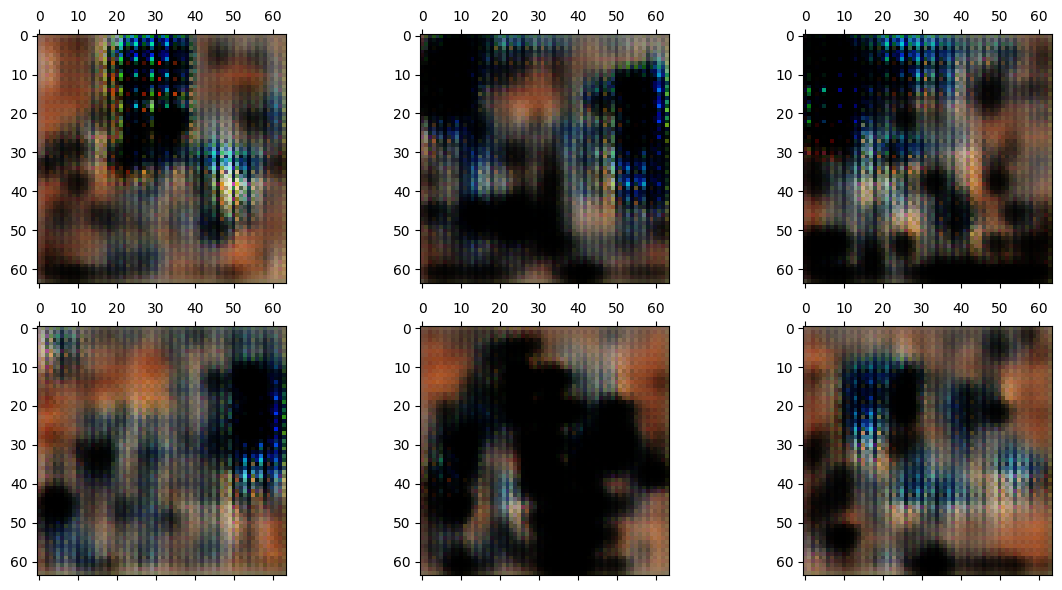

1/1 [==============================] - 1s 1s/step
Epoch number:  900
*** Training ***
Discriminator Loss  0.6851659417152405
Generator Loss:  0.7178264260292053
2/2 [==============================] - 3s 1s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.9399999976158142
Discriminator Accuracy on FAKE (generated) images:  0.3199999928474426


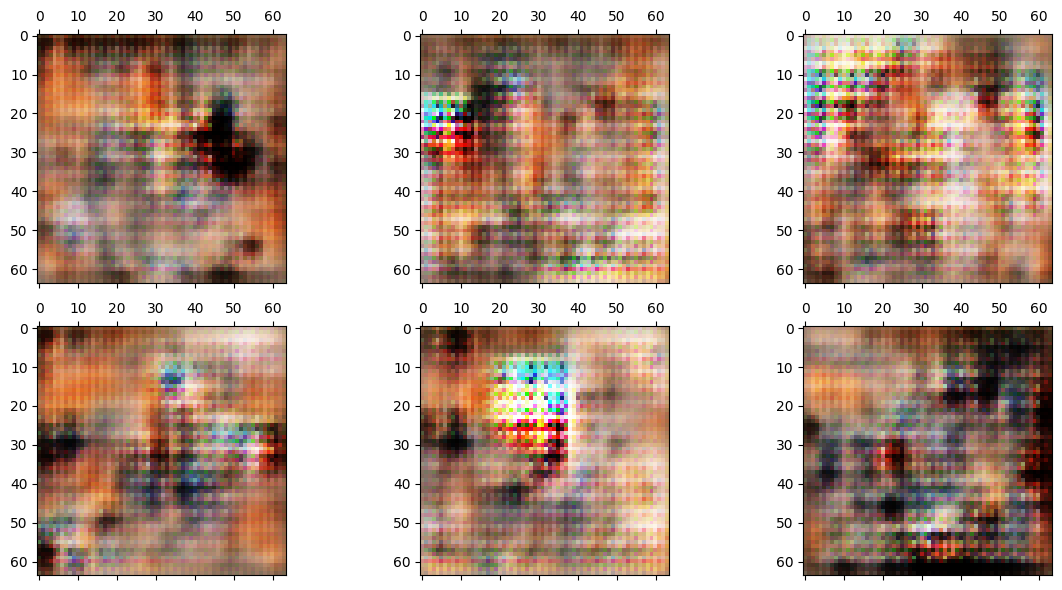

1/1 [==============================] - 1s 1s/step
Epoch number:  1000
*** Training ***
Discriminator Loss  0.6459251642227173
Generator Loss:  0.7972803115844727
2/2 [==============================] - 4s 1s/step
*** Evaluation ***
Discriminator Accuracy on REAL images:  0.7200000286102295
Discriminator Accuracy on FAKE (generated) images:  0.6399999856948853


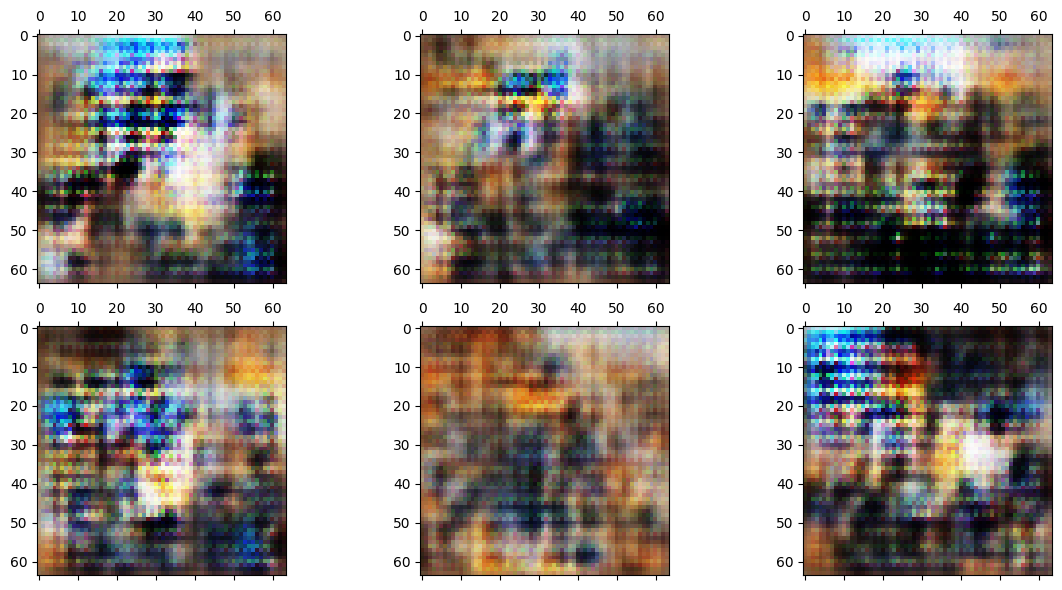

In [30]:
# Train DCGAN model
train(gen_model, dis_model, gan_model, data, latent_dim)